In [433]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import statsmodels.api as sm
import datetime 

Given that this problem involves multiple dataset, the process is divided in the following

**1.** Micro EDA- An Exploratory Data Analysis of just one dataset

**2.** Micro clustering

**3.** Data unification

**4.** Global clusters

**5.** Forecasting

**6.** Bonus problem

# Micro EDA

Let's analyze just one month

In [434]:
data_2017_01 = pd.read_excel('./data/2017_01_purchases.xls')
data_2017_01.head()

,TRANS DATE,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
0,2017-01-03,VR,72.61,GBP,72.61,GBP,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
1,2017-01-24,VR,85.51,GBP,85.51,GBP,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities
2,2017-02-01,VR,10.09,GBP,10.09,GBP,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities
3,2017-01-04,VR,20.00,GBP,20.00,GBP,mibsons service st,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities
4,2017-01-05,VR,50.00,GBP,50.00,GBP,malthurst petroleu,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities


In [435]:
data_2017_01['card_number'] = data_2017_01['CARD NUMBER'].apply(lambda x: x.replace('*', ''))
data_2017_01['card_number'] = pd.to_numeric(data_2017_01['card_number'])
data_2017_01['Directorate'] = data_2017_01['Directorate'].apply(lambda x: x.replace(' ', '')).str.lower()

In [436]:
data_2017_01.columns

Index(['TRANS DATE', 'TRANS VAT DESC', 'ORIGINAL GROSS AMT', 'ORIGINAL CUR',
       'BILLING GROSS AMT', 'BILLING CUR CODE', 'MERCHANT NAME', 'CARD NUMBER',
       'TRANS CAC CODE 1', 'TRANS CAC DESC 1', 'TRANS CAC CODE 2',
       'TRANS CAC DESC 2', 'TRANS CAC CODE 3', 'Directorate', 'card_number'],
      dtype='object')

In [437]:
data_2017_01['Directorate'].drop_duplicates()

0        adult&communities
247                 adults
252     corporateresources
496                  cyp&f
998           cyp&fschools
4007           development
4066         localservices
Name: Directorate, dtype: object

With a quick EDA, we can see that there are some anomalies. Although simple for the detection of anomalies, we can do a better process for the detection of the anomalies

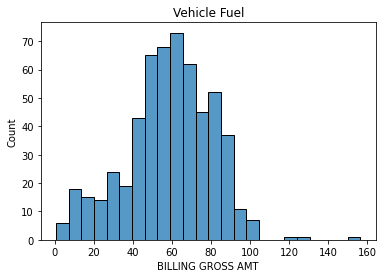

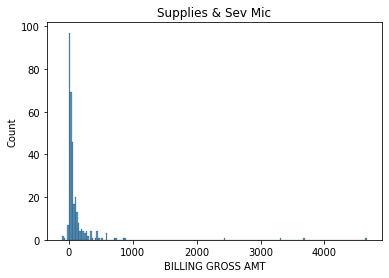

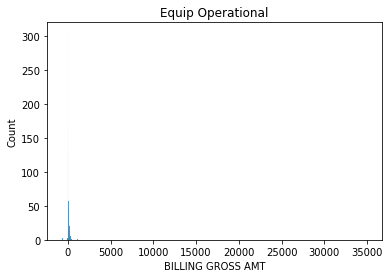

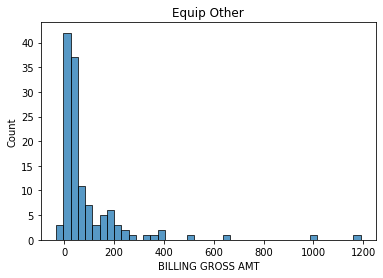

In [438]:
for transactions in data_2017_01['TRANS CAC DESC 1'].drop_duplicates()[:4]:
    fig, ax = plt.subplots()
    sns.histplot(data_2017_01.loc[data_2017_01['TRANS CAC DESC 1'] == transactions],x='BILLING GROSS AMT').set_title(transactions)
    plt.show()

Based on these histograms we found some anomalies, specially in the supplies and services and equip operational. Let's plot it in clusters so we can have a better  visualization

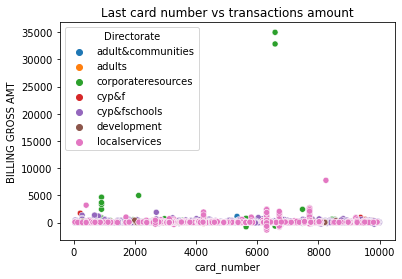

In [439]:
#plt.scatter(data_2017_01['card_number'], data_2017_01['BILLING GROSS AMT'], alpha=.2, label='TRANS CAC DESC 1')
sns.scatterplot(data=data_2017_01, x="card_number", y="BILLING GROSS AMT", hue="Directorate").set_title('Last card number vs transactions amount')
plt.show()

More useful than he other and we can say that corporate resources has at least two anomalies while local services has only one in the eyesight, but more can be done. First, let's join the data

Since this is a 1D data with all the rest of the features are factors or datetimes, instead of clusters we can use IQR outlier list and the three sigma rule

In [440]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [441]:
global_lowerbound,global_upperbound = outlier_treatment(data_2017_01['BILLING GROSS AMT'])

In [442]:
data_2017_01['Outlier'] = (data_2017_01['BILLING GROSS AMT']>global_upperbound) | (data_2017_01['BILLING GROSS AMT']< global_lowerbound)

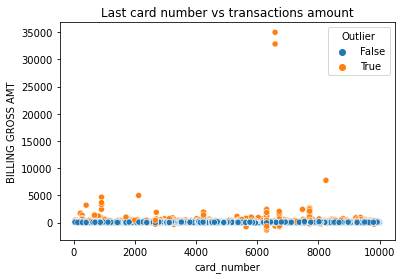

The outliers are the 11.50% of the cases


In [443]:
sns.scatterplot(data=data_2017_01, x="card_number", y="BILLING GROSS AMT", hue="Outlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_2017_01['Outlier'].sum()/data_2017_01['Outlier'].shape[0]*100))

Now, some areas areas have different scales than others, thus if I buy a car even its first monthly pay can be considered as an outlier if I group it with the groceries shopping costs. To reduce the number of outliers let's make a local outlier detection by directorate and type of purchase

In [444]:
def get_local_outliers(row, df, column):
    try:
        lower, upper = outlier_treatment(df.loc[df[column]==row[column]]['ORIGINAL GROSS AMT'])
        return (row['ORIGINAL GROSS AMT']>upper) | (row['ORIGINAL GROSS AMT']< lower)
    except:
        #print(row)
        return False

In [445]:
data_2017_01['IsDirectorateOutlier']=data_2017_01.apply(lambda x: get_local_outliers(x,data_2017_01,'Directorate'),axis=1)

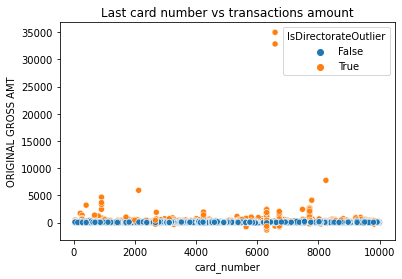

The outliers are the 10.92% of the cases


In [446]:
sns.scatterplot(data=data_2017_01, x="card_number", y="ORIGINAL GROSS AMT", hue="IsDirectorateOutlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_2017_01['IsDirectorateOutlier'].sum()/data_2017_01.shape[0]*100))

It is a .58% of difference, let's try with a more refined category

In [447]:
data_2017_01['IsAreaOutlier']=data_2017_01.apply(lambda x: get_local_outliers(x,data_2017_01,'TRANS CAC DESC 1'),axis=1)

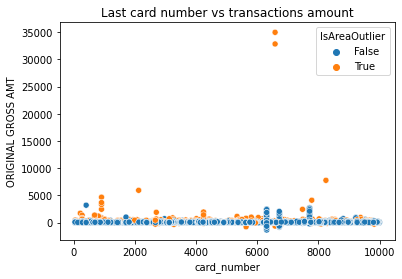

The outliers are the 7.81% of the cases


In [448]:
sns.scatterplot(data=data_2017_01, x="card_number", y="ORIGINAL GROSS AMT", hue="IsAreaOutlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_2017_01['IsAreaOutlier'].sum()/data_2017_01.shape[0]*100))

Now this make more sense. 7.81 is still a high number yet it is a more accurate way of classifying outliers

In [449]:
data_2017_01['IsCardOutlier']=data_2017_01.apply(lambda x: get_local_outliers(x,data_2017_01,'card_number'),axis=1)

Finally, as an experiment, we will go granular and go for the card number

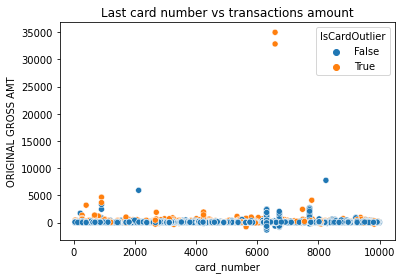

The outliers are the 9.18% of the cases


In [450]:
sns.scatterplot(data=data_2017_01, x="card_number", y="ORIGINAL GROSS AMT", hue="IsCardOutlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_2017_01['IsCardOutlier'].sum()/data_2017_01.shape[0]*100))

For the global analysis we are going to work with the area analysis since it is much better at getting outliers.

## Data unification

From all the files downloaded, the only that had no purchase information was from December 2017. To improve the prediction power of the algorithm, the data from 2014 to the end of 2018 was collected

In [451]:
datasets = ['2014_04_purchases.xls','2014_05_purchases.xls','2014_06_purchases.xls','2014_07_purchases.xls',
'2014_08_purchases.xls','2014_09_purchases.xls','2014_10_purchases.xls','2014_11_purchases.xls','2014_12_purchases.xls',
'2015_01_purchases.xls','2015_02_purchases.xls','2015_03_purchases.xls','2015_05_purchases.xls','2015_06_purchases.xls','2015_07_purchases.xls',
'2015_08_purchases.xls','2015_09_purchases.xls','2015_10_purchases.xls','2015_11_purchases.xls','2015_12_purchases.xls','2016_01_purchases.xls','2016_02_purchases.xls',
'2016_03_purchases.xls','2016_04_purchases.xls','2016_05_purchases.xls','2016_06_purchases.xls','2016_07_purchases.xls','2016_08_purchases.xls','2016_09_purchases.xls',
'2016_10_purchases.xls','2016_11_purchases.xls','2016_12_purchases.xls','2017_01_purchases.xls','2017_02_purchases.xls','2017_03_purchases.xls','2017_04_purchases.xls',
'2017_05_purchases.xls','2017_06_purchases.xls','2017_07_purchases.xls','2017_08_purchases.xls','2017_09_purchases.xls','2017_10_purchases.xls','2017_11_purchases.xls',
'2018_01_purchases.xls','2018_02_purchases.xls',
'2018_03_purchases.xls','2018_04_purchases.xls','2018_05_purchases.xls','2018_06_purchases.xls','2018_07_purchases.xls','2018_08_purchases.xls','2018_09_purchases.xls',
'2018_10_purchases.xls','2018_11_purchases.xls','2018_12_purchases.xls']

After looking at all the files, the most important columns found were the transaction date, the original amount paid, the card number, the type of transaction and the directory that did it

In [452]:
data_columns = ['TRANS DATE','ORIGINAL GROSS AMT','CARD NUMBER','TRANS CAC DESC 1','Directorate']
data_consolidated = pd.DataFrame(columns = data_columns)
#Critical columns 
for element in datasets:
    data = pd.read_excel('./data/'+element)
    data_consolidated = data_consolidated.append(data[data_columns])
    pass
print(f'The data has {data_consolidated.shape[0]} rows')

The data has 236039 rows


Once it is loaded, the empty fields are removed. Another thing that was done an is to merge Directorates that were different by minimal things such as capitalization or a missing letter. The following segment corrects all the problems and I also converted the card numbers into int for visualization only

In [453]:
data_consolidated = data_consolidated.dropna()
data_consolidated['Directorate'] = data_consolidated['Directorate'].apply(lambda x: x.replace(' ', '')).str.lower()
data_consolidated['Directorate'].replace({"adults&communities":"adult&communities"},inplace=True)
data_consolidated['Directorate'].replace({"adults&comms":"adult&communities"},inplace=True)
data_consolidated['Directorate'].replace({"adultsocialcareadhealth":"adultsocialcareandhealth"},inplace=True)
data_consolidated['Directorate'].replace({"cyo&f":"cyp&f"},inplace=True)
data_consolidated['card_number'] = data_consolidated['CARD NUMBER'].apply(lambda x: x.replace('*', ''))
data_consolidated['card_number'] = pd.to_numeric(data_consolidated['card_number'])

In [454]:
data_consolidated['Directorate'].drop_duplicates()

0              adult&communities
241           corporateresources
489                        cyp&f
980                 cyp&fschools
1875                 development
1994               localservices
209         corporateprocurement
441                       adults
0       adultsocialcareandhealth
579                    cyp&f-bct
0                        acivico
248     birminghamchildrenstrust
Name: Directorate, dtype: object

Once the data is consolidated let's do the the anomaly detection. First, let's define the upper and lower limits

In [455]:
def get_upper_outliers(row, df, column):
    lower, upper = outlier_treatment(df.loc[df[column]==row[column]]['ORIGINAL GROSS AMT'])
    return upper

def get_lower_outliers(row, df, column):
    lower, upper = outlier_treatment(df.loc[df[column]==row[column]]['ORIGINAL GROSS AMT'])
    return lower

Then, it is time to create a dataframe with the upper and lower limits for each spending category

In [456]:
types_purchases = data_consolidated['TRANS CAC DESC 1'].drop_duplicates().values
#Creating a dataframe for as a pseudo dictionary
df_areas_outliers = pd.DataFrame(columns = ['TRANS CAC DESC 1'], data = types_purchases)
df_areas_outliers['upper_outlier']=df_areas_outliers.apply(lambda x: get_upper_outliers(x,data_consolidated,'TRANS CAC DESC 1'),axis=1)
df_areas_outliers['lower_outlier']=df_areas_outliers.apply(lambda x: get_lower_outliers(x,data_consolidated,'TRANS CAC DESC 1'),axis=1)
df_areas_outliers.head().sort_values(by=['TRANS CAC DESC 1'])


,TRANS CAC DESC 1,upper_outlier,lower_outlier
2,Computing Other,293.5050,-145.1750
4,Equip Other,202.2400,-99.7600
1,Training Other,475.0000,-205.0000
3,Vehicle Excise Lics,564.2500,-333.7500
0,Vehicle Fuel,114.2875,2.5475


Let's merge the previously created dataset. Then a simple logical operation is used to define if an amount is an outlier or not

In [457]:
data_consolidated_with_bounds = pd.merge(left=data_consolidated,right=df_areas_outliers, on='TRANS CAC DESC 1', how='left')

In [458]:
data_consolidated_with_bounds['IsOutlier'] = (data_consolidated_with_bounds['ORIGINAL GROSS AMT']>data_consolidated_with_bounds['upper_outlier']) | (data_consolidated_with_bounds['ORIGINAL GROSS AMT']<data_consolidated_with_bounds['lower_outlier'])

In [459]:
data_consolidated_with_bounds.head()

,TRANS DATE,ORIGINAL GROSS AMT,CARD NUMBER,TRANS CAC DESC 1,Directorate,card_number,upper_outlier,lower_outlier,IsOutlier
0,2014-04-29,52.32,************5770,Vehicle Fuel,adult&communities,5770,114.2875,2.5475,False
1,2014-04-04,65.82,************5770,Vehicle Fuel,adult&communities,5770,114.2875,2.5475,False
2,2014-04-07,41.35,************8738,Vehicle Fuel,adult&communities,8738,114.2875,2.5475,False
3,2014-04-25,47.19,************2997,Vehicle Fuel,adult&communities,2997,114.2875,2.5475,False
4,2014-04-24,98.08,************2997,Vehicle Fuel,adult&communities,2997,114.2875,2.5475,False


Finally, let's plot the outliers with the rest of the dataset

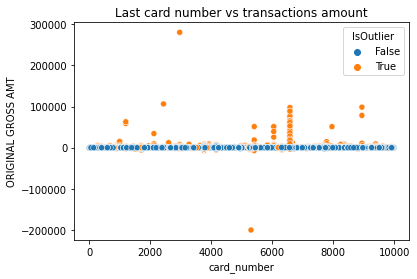

The outliers are the 8.41% of the cases


In [460]:
sns.scatterplot(data=data_consolidated_with_bounds, x="card_number", y="ORIGINAL GROSS AMT", hue="IsOutlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_consolidated_with_bounds['IsOutlier'].sum()/data_consolidated_with_bounds.shape[0]*100))

## Forecasting

Since the outliers are about 8.41% of the pursues we will have to remove them in order to do the time series

In [461]:
data_consolidated_cleared = data_consolidated_with_bounds.copy()
data_consolidated_cleared = data_consolidated_cleared.loc[data_consolidated_cleared.IsOutlier == False]
data_consolidated_cleared.shape[0]

215356

Now that we cleared the data, is time to put the data in terms of mean for each month. Also, we can do an whole analysis of for category. To simplify the process, the forecast will be done in the global purchases. The next thing is to change the column names for a better format and just work with the date and the amounts

In [462]:
timed_data = data_consolidated_cleared.copy()[['TRANS DATE','ORIGINAL GROSS AMT']]
timed_data = timed_data.rename(columns={"TRANS DATE": "date", "ORIGINAL GROSS AMT": "purchase"})
timed_data.head()

,date,purchase
0,2014-04-29,52.32
1,2014-04-04,65.82
2,2014-04-07,41.35
3,2014-04-25,47.19
4,2014-04-24,98.08


Since we need to predict, we create a train dataset. In this case the train dataset will be from April 2014 to November 2017

timed_data_train = timed_data.loc[timed_data.date < datetime.datetime(2017,12,1)]
timed_data_train = timed_data_train.loc[timed_data.date >= datetime.datetime(2014,4,1)]

In [463]:
tst = timed_data_train.groupby('date')['purchase'].sum().reset_index()
tst = tst.set_index('date')
y2 = tst['purchase'].resample('MS').mean()

Also, let's keep the whole time series for benchmark and to evaluate the performance of the model

In [464]:
tst2 =  timed_data.groupby('date')['purchase'].sum().reset_index()
tst2 = tst2.set_index('date')
y_full = tst2['purchase'].resample('MS').mean()

For this case, we are going to use Seasonal Autoregressive Integrated Moving Average(ARIMA). Its performance will determinate if the time series is complex or linear

In [465]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [466]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        pass
    pass

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:950.4326338371693
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1409.361589498813
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:648.7224780458355
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:412.60460326651383


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
d:\Globant\Task2\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:660.0430623037496
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:628.7780627695787
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:426.50351109621374
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:394.6068918918894
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:906.917256960289


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3196.380265183829
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:620.161990459886
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:378.7868087661445
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:657.8438604241453
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:643.4901255571345
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:421.06635520731595
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:375.0402071605211
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:822.5982268198776
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1430.7970439294088
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:598.2532854300841


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:353.34505545849356
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:599.562489426586


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:898.3236421250542
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:371.27156281394844
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:350.16597311973885
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:787.779972512061
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2325.082623168203
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:570.6086677026487


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:335.59036891282386
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:598.872522446367


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2301.227203188815
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:373.7485254278236
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:336.42832865419575
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:844.3964209462372
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2943.5478792535246
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:620.8107619013316
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:376.72506047485984
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:602.2171627609542
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:602.9080211616447
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:375.75205564175513
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:377.626618239014
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:817.8025115584501
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2434.5961500415337
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:596.9581411652507
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:356.5635141905512
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:596.6898544154704
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:578.0599055442005
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:375.3373507923669
ARIMA(

d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1350.2745010353617
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:590.1827070917361
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:353.3863745874213
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:579.3240619432555


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1313.7918281667387
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:354.2898152649728
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:354.55645702688435
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:789.0750947681773


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2185.877067081998
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:569.1672130677493
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:333.45526752514246
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:576.6205158673797


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2448.6895647891174
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:353.3977693350481
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:334.65231511106157


Creating a seasonal ARIMA model for forecasting

In [467]:
mod = sm.tsa.statespace.SARIMAX(y2,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0051      0.060    -16.654      0.000      -1.123      -0.887
ma.L1          0.9828      0.485      2.027      0.043       0.033       1.933
ar.S.L12      -0.5031      0.291     -1.726      0.084      -1.074       0.068
sigma2      1.664e+07    1.3e-08   1.28e+15      0.000    1.66e+07    1.66e+07


Let's forecast the purchases for the year 2018. For that, we introduced the time limits

In [468]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'),end=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()

Plotting the whole evolution

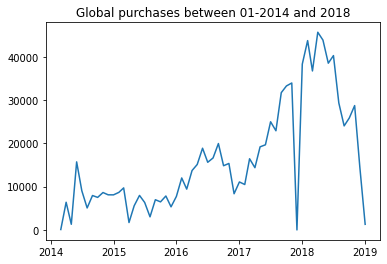

In [469]:
plt.plot(y_full)
plt.title('Global purchases between 01-2014 and 2018')
plt.show()

Let's predict the purchases for 2018

Text(0.5, 1.0, 'Predicted purchases for the year 2018')

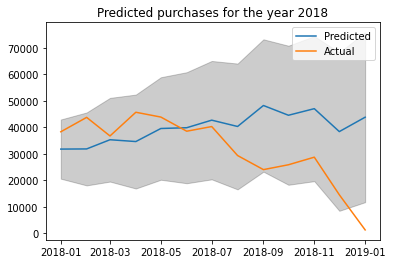

In [470]:
plt.plot(pred.predicted_mean)
plt.plot(y_full['2018':'2019'])
plt.legend(["Predicted", "Actual"], loc ="upper right")
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Predicted purchases for the year 2018')

In [471]:
y_forecasted = pred.predicted_mean
y_truth = y_full['2018':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 316232550.81
The Root Mean Squared Error of our forecasts is 17782.93


Given the amount of datapoints it is expected that the model underperforms in the beggining but it detects the decrease in the purchases by septmber and the low in December. With a couple of years more of data. Its performance may increase. One factor that alters everything is the absence of data from December 2017

## Creative problem

At first I though on the idea of using a classification problem to detect the contributing features to the anomalies. However, it we have few features and we have abnormalities all the months.

In [472]:
data_consolidated_with_bounds.columns

Index(['TRANS DATE', 'ORIGINAL GROSS AMT', 'CARD NUMBER', 'TRANS CAC DESC 1',
       'Directorate', 'card_number', 'upper_outlier', 'lower_outlier',
       'IsOutlier'],
      dtype='object')

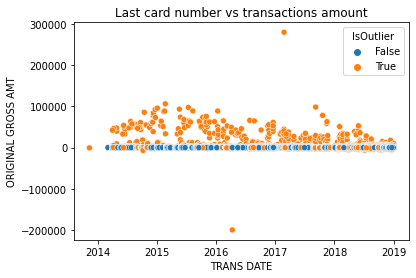

In [473]:
sns.scatterplot(data=data_consolidated_with_bounds, x="TRANS DATE", y="ORIGINAL GROSS AMT", hue="IsOutlier").set_title('Last card number vs transactions amount')
plt.show()

Let's see if the data is enough for a RNN

In [503]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [522]:
# load dataset
raw_values = y_full.values
diff_values = difference(raw_values, 1)

In [505]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [506]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [507]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

This LTSM is god but we need to reduce the LSTM size because it takes too much to compile

In [508]:
# repeat experiment
repeats = 10
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 200, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

1) Test RMSE: 11533.824
2) Test RMSE: 13037.303
3) Test RMSE: 12196.488
4) Test RMSE: 11515.418
5) Test RMSE: 11347.603
6) Test RMSE: 11038.835
7) Test RMSE: 11491.325
8) Test RMSE: 11771.794
9) Test RMSE: 11318.492
10) Test RMSE: 12177.362


By simply watching the RNN latest RMSE and compared to the one from seasonal ARIMA (**RMSE=17782.93**), we can see that the RNN provided in this case a better forecast

Text(0.5, 1.0, 'Predicted purchases for the year 2018')

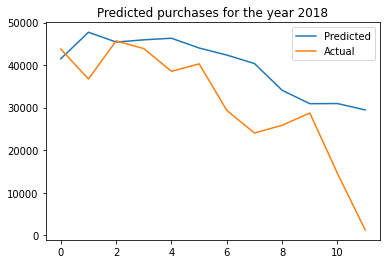

In [523]:
plt.plot(predictions)
plt.plot(y_full[-12:].values)
plt.legend(["Predicted", "Actual"], loc ="upper right")
plt.title('Predicted purchases for the year 2018')

In the latest plot we can see that the forecasting follows the pattern better compared to the ARIMA

## References

* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b